In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#Reading .json file

data = pd.read_json('tops_fashion.json')

In [ ]:
data.describe()

In [7]:
print('Total features in the given json file are :',data.shape[1])

Total features in the given json file are : 19


In [8]:
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

In [9]:
data['asin'].head()

0    B016I2TS4W
1    B01N49AI08
2    B01JDPCOHO
3    B01N19U5H5
4    B004GSI2OS
Name: asin, dtype: object

In [10]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [11]:
data.describe()

asin   brand  color  \
count       183138  182987  64956   
unique      183138   10577   7380   
top     B01EIJ3LS6    Zago  Black   
freq             1     223  13207   

                                         medium_image_url product_type_name  \
count                                              183138            183138   
unique                                             170782                72   
top     https://images-na.ssl-images-amazon.com/images...             SHIRT   
freq                                                   23            167794   

                                                    title formatted_price  
count                                              183138           28395  
unique                                             175985            3135  
top     Nakoda Cotton Self Print Straight Kurti For Women          $19.99  
freq                                                   77             945

In [12]:
data['product_type_name'].unique()

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [14]:
#Top 10 products type in the database
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [15]:
#Top 10 brands type in the database
brands_count = Counter(list(data['brand']))
brands_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [16]:
#Top 10 color type in the database
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

## Checkpoint 1

### At every check point we will be exporting our modified dataset so that we can run our codes in byparts.Also, in this project we will be working on several recommendation models where codes can run seperaretly.

In [25]:

data.to_pickle('pickels/180k_apparel_data')

### Removing NuLL values 

In [19]:
data = data.loc[~data['formatted_price'].isnull()]  #~is used when we dont have to consider that points
print('Final number of records in data after deleting null values :', data.shape[0])

Final number of records in data after deleting null values : 28395


In [27]:
data = data.loc[~data['color'].isnull()]  #~is used when we dont have to consider that points
print('Final number of records in data after deleting null values :', data.shape[0])

Final number of records in data after deleting null values : 28385


In [28]:
data.to_pickle('pickels/28k_apparel_data')   #saving as s pickle file at each important step

### Removing Near Duplicate Items

In [38]:
data = pd.read_pickle('pickels/28k_apparel_data')

In [39]:
sum(data.duplicated('title'))

2325

In [41]:
#Removing data points with small tittles say less than 5 words

data_sorted= data[data['title'].apply(lambda x : len(x.split())>4)]
print('Number of records in data after deleting very small title products :', data_sorted.shape[0])

Number of records in data after deleting very small title products : 27949


In [45]:
#Sorting titles in order
data_sorted.sort_values('title',inplace = True,ascending =False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [101]:
##Removing last couple of words from the tittle so that we could count data points with different color and size as 1

indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [102]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [106]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [110]:
data.to_pickle('pickels/17k_apparel_data') 

In [111]:
# This code snippet
# Takes about an hour to run on a dec takes significant amount of time.
# O(n^2) time.ent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(a))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [114]:
data.to_pickle('pickels/16k_apparel_data')


In [2]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')


## Data Preprocessing 

#### At first, we will be removing stopwords from our title given


In [160]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(text,index,column):
    
    if type(text) is not int:
        string = ""
        
        for words in text.split():
            #removing special characters 
            word =("".join(e for e in words if e.isalnum()))
            
      #Lower casing all the words
            word = word.lower()
          
        #Removing all the stopwords possibly present
            if not word in stop_words:
                string += word + " "
            data[column][index] = string
        

In [161]:
start_time = time.clock()

for index,row in data.iterrows():
    nlp_preprocessing(row['title'],index,'title')
    
print(time.clock() - start_time,"seconds")

17.673530999998547 seconds


In [162]:
data.shape

(16042, 7)

### Several Utilities Function

In [3]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## 1.Bag of Words(BoW) on Product titles

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

In [172]:
def bag_of_words_model(doc_id,num_results):
    
    
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    
    #dataframe indices of the 9 smallest distance
    df_indices = list(data.index[indices])
    
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    

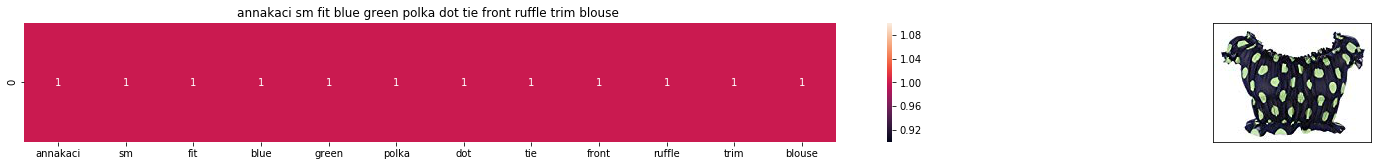

ASIN : B00KLHUIBS
Brand: Anna-Kaci
Title: annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Euclidean similarity with the query image : 0.0


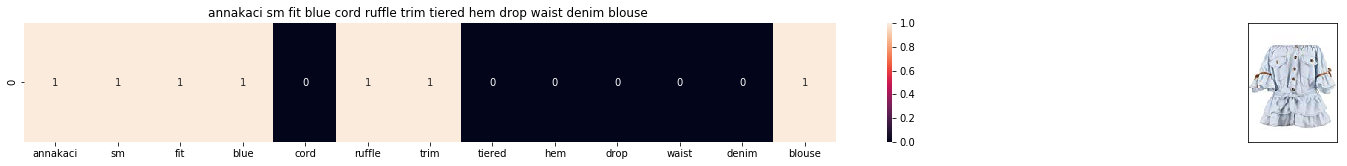

ASIN : B0759G15ZX
Brand: Anna-Kaci
Title: annakaci sm fit blue cord ruffle trim tiered hem drop waist denim blouse 
Euclidean similarity with the query image : 3.3166247903554


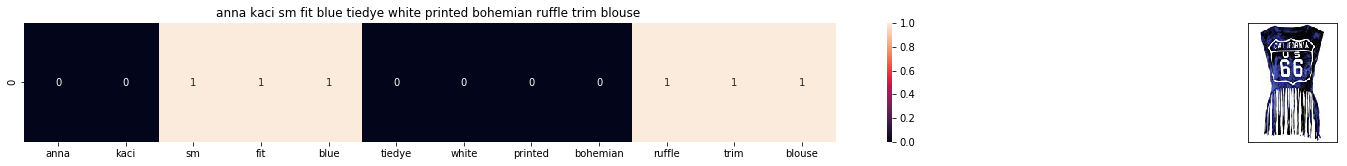

ASIN : B00YQ8S4K0
Brand: Anna-Kaci
Title: anna kaci sm fit blue tiedye white printed bohemian ruffle trim blouse 
Euclidean similarity with the query image : 3.4641016151377544


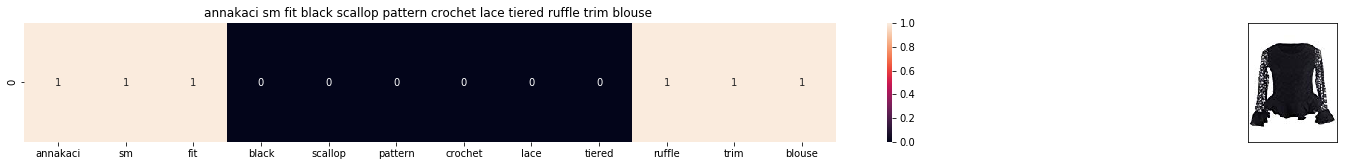

ASIN : B00O194W8W
Brand: Anna-Kaci
Title: annakaci sm fit black scallop pattern crochet lace tiered ruffle trim blouse 
Euclidean similarity with the query image : 3.4641016151377544


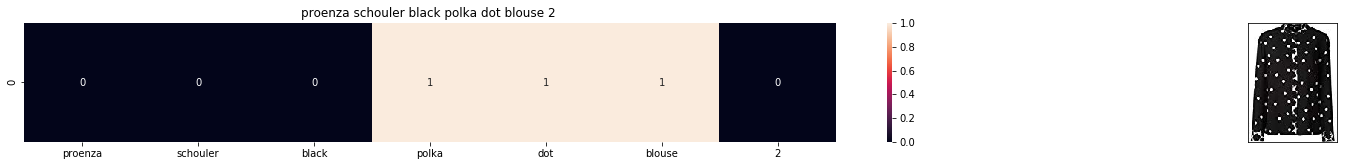

ASIN : B074TLHLMN
Brand: Proenza Schouler
Title: proenza schouler black polka dot blouse 2 
Euclidean similarity with the query image : 3.4641016151377544


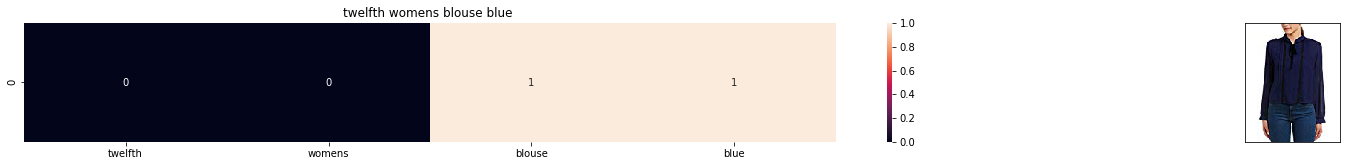

ASIN : B074F5BP5F
Brand: On Twelfth
Title: twelfth womens blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


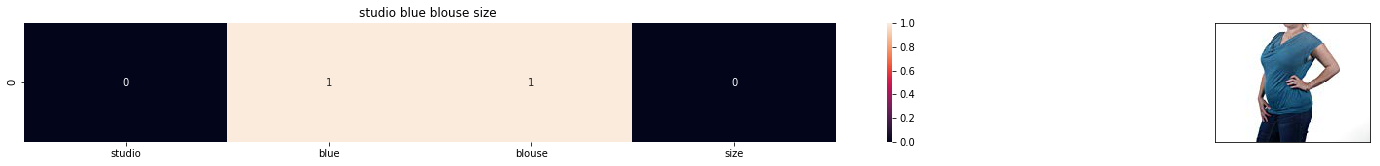

ASIN : B016P80OKQ
Brand: Studio M
Title: studio blue blouse size 
Euclidean similarity with the query image : 3.4641016151377544


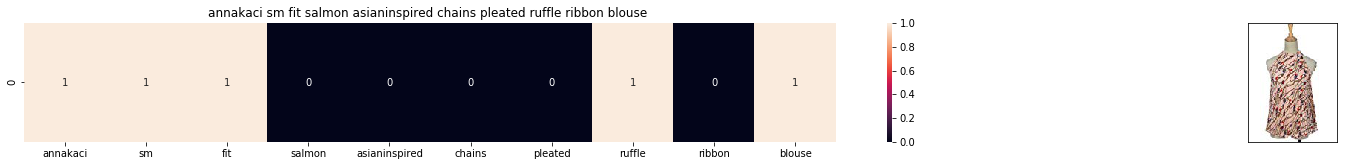

ASIN : B007KSG42S
Brand: Anna-Kaci
Title: annakaci sm fit salmon asianinspired chains pleated ruffle ribbon blouse 
Euclidean similarity with the query image : 3.4641016151377544


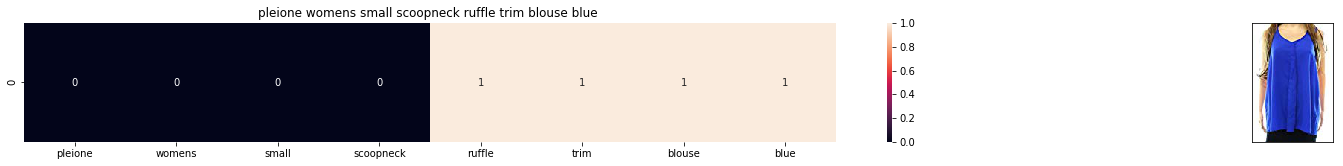

ASIN : B072VHTT1D
Brand: Pleione
Title: pleione womens small scoopneck ruffle trim blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


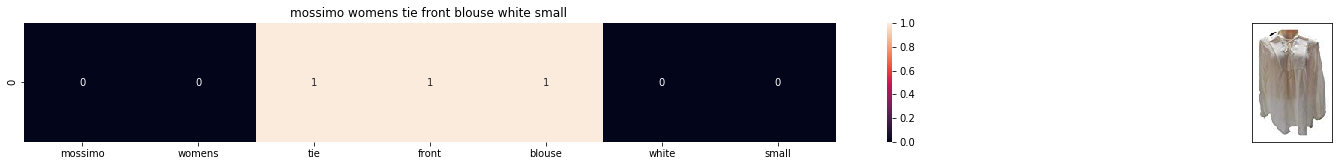

ASIN : B07111HHX6
Brand: Mossimo
Title: mossimo womens tie front blouse white small 
Euclidean similarity with the query image : 3.605551275463989


In [173]:
bag_of_words_model(931,10)

In [11]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

### TF-IDF On Product Titles

In [ ]:
def tfidf_model(doc_id,num_results):
    
    pairwise_dist= pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists   = np.sort(pairwise_dist.flatten())[0:num_results]

    
    df_indices = list(data.index[indices])
    
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
        
        

    

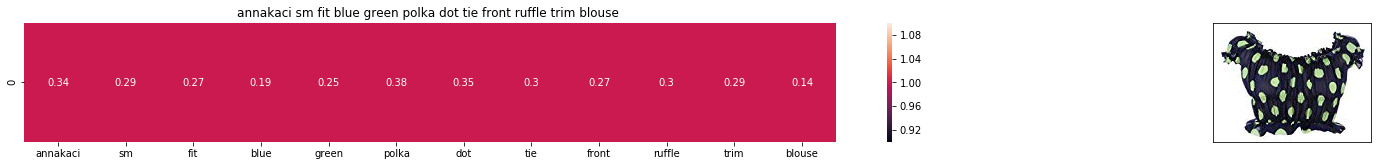

ASIN : B00KLHUIBS
BRAND : Anna-Kaci
Eucliden distance from the given image : 0.0


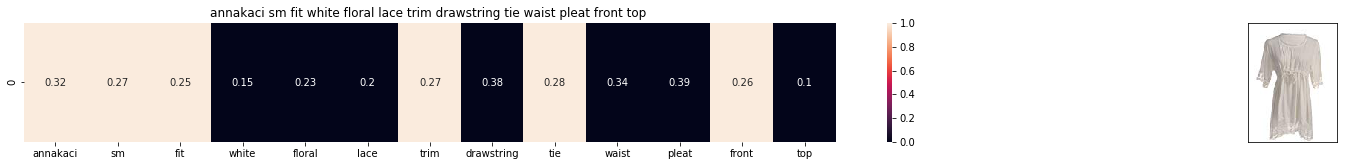

ASIN : B00DW1NKSS
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.0095030470167985


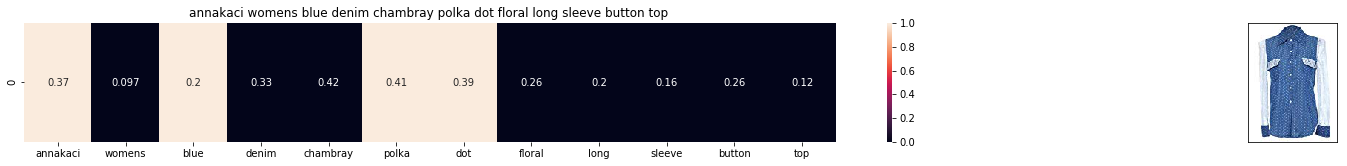

ASIN : B008SMIFN6
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.0417985120306876


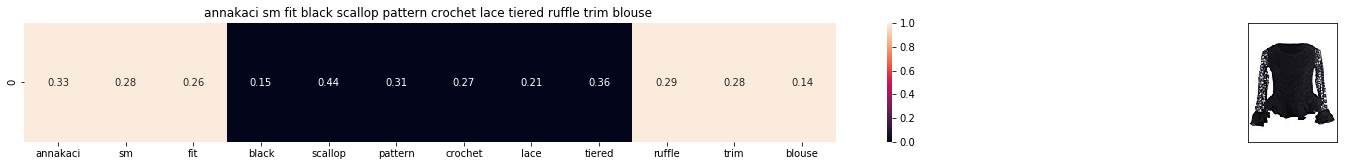

ASIN : B00O194W8W
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.0459904789057266


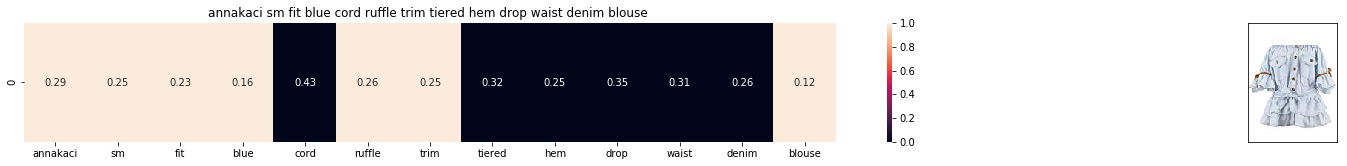

ASIN : B0759G15ZX
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.0670382891349643


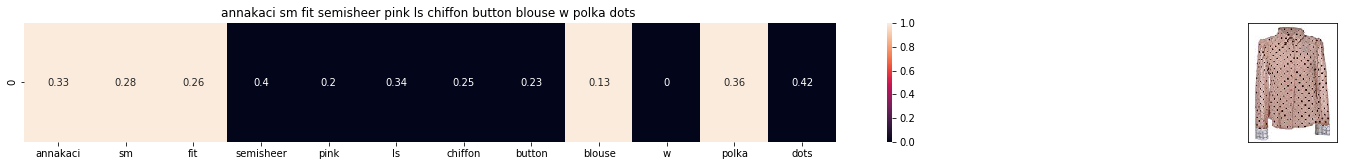

ASIN : B008Z5ST3C
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.079194342831273


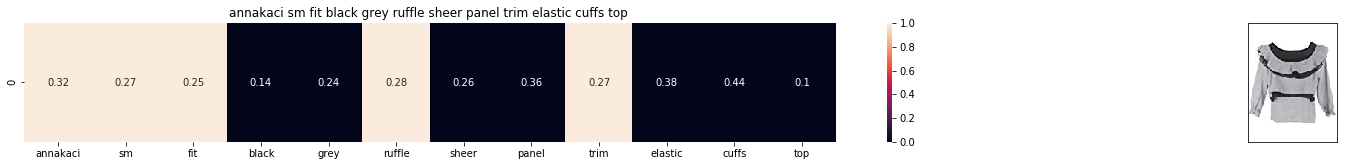

ASIN : B00OIBU11K
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.0810642547494658


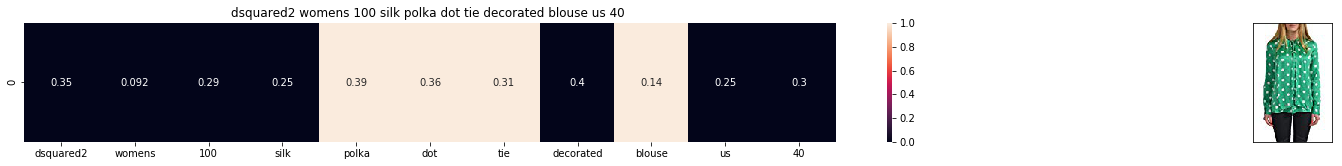

ASIN : B01AYBH28M
BRAND : DSQUARED2
Eucliden distance from the given image : 1.1040520792000035


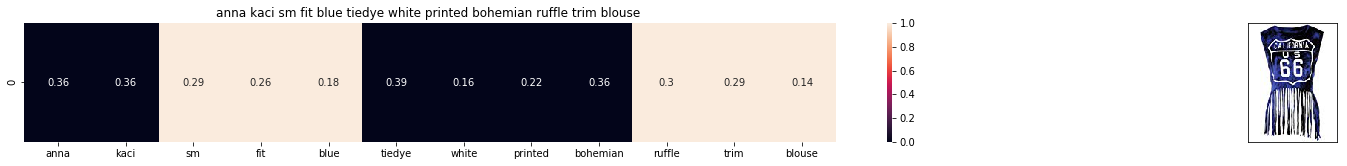

ASIN : B00YQ8S4K0
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.1106318669558235


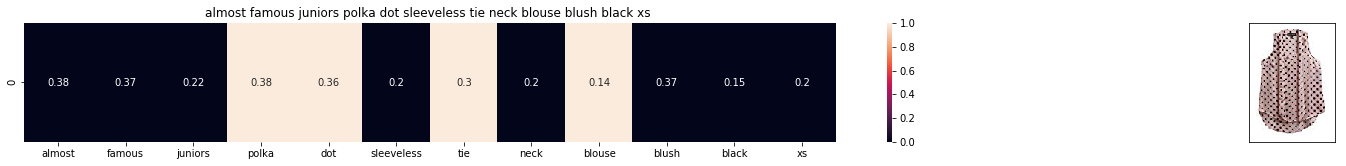

ASIN : B0745J9HNS
BRAND : Almost Famous
Eucliden distance from the given image : 1.1114784382103975


In [196]:
tfidf_model(931,10)

## Text Semantics based product similarity ( Word2Vec )

##### Here we generally have two options
1.Download Google News pretrained model to have 300d vectors for every word present.
<br/>2.Make your own corpus using the available words in the datasets. Remember that the word corpus should have huge   number of unique words but in our case we have just 12k.

In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


with open('word2vec_model','rb') as handle:
    model = pickle.load(handle)

In [8]:
#Some Important Utilities functions


# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [9]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec    

### Average Word2Vec product similarity

In [16]:
doc_id = 0
w2v_title = []

for i in data['title']:
    w2v_title.append(build_avg_vec(i,300,doc_id,'avg'))
    doc_id += 1
    
    
w2v_title = np.array(w2v_title)


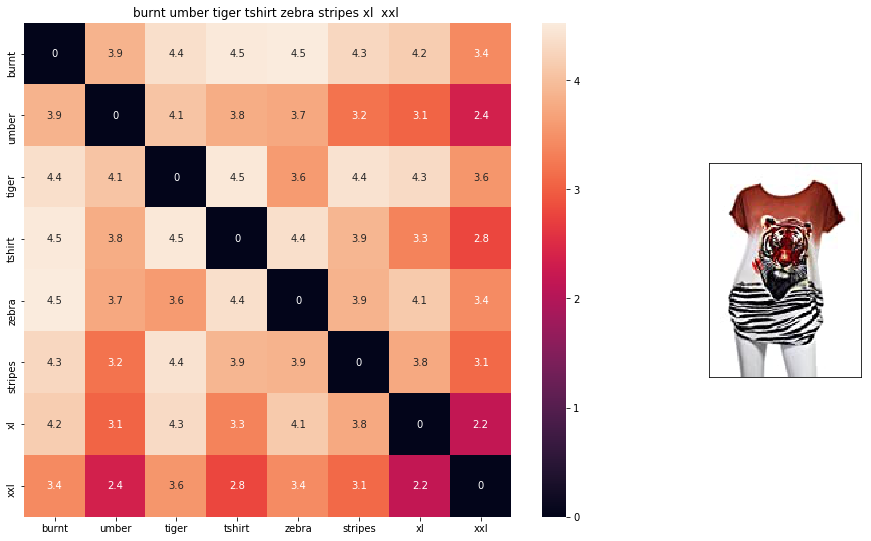

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.0


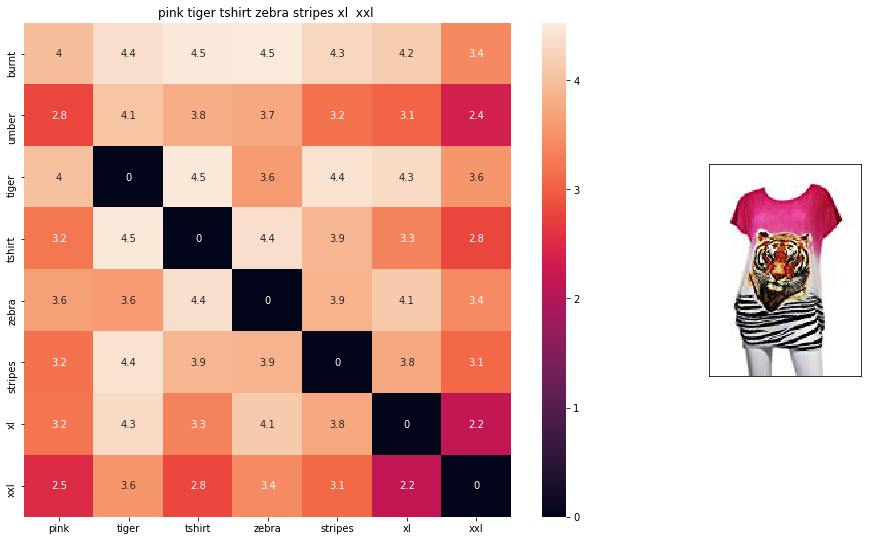

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.5891928


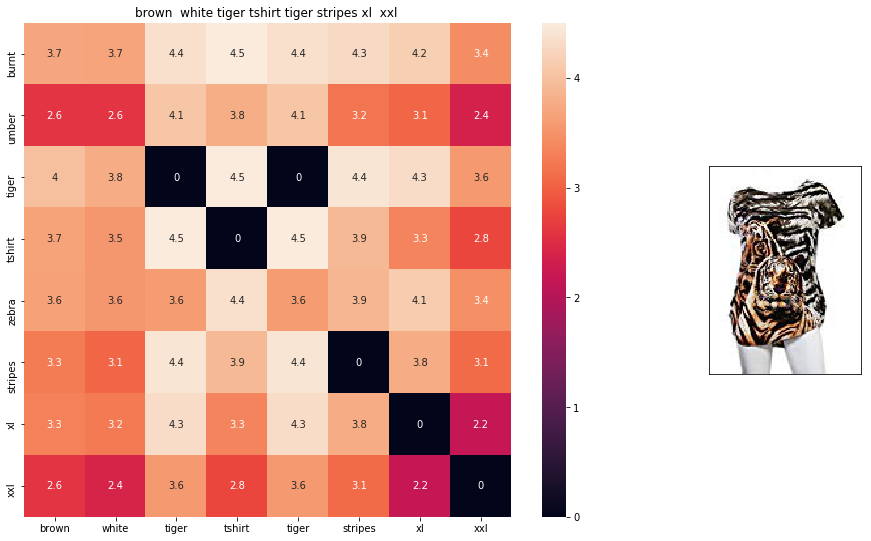

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.7003436


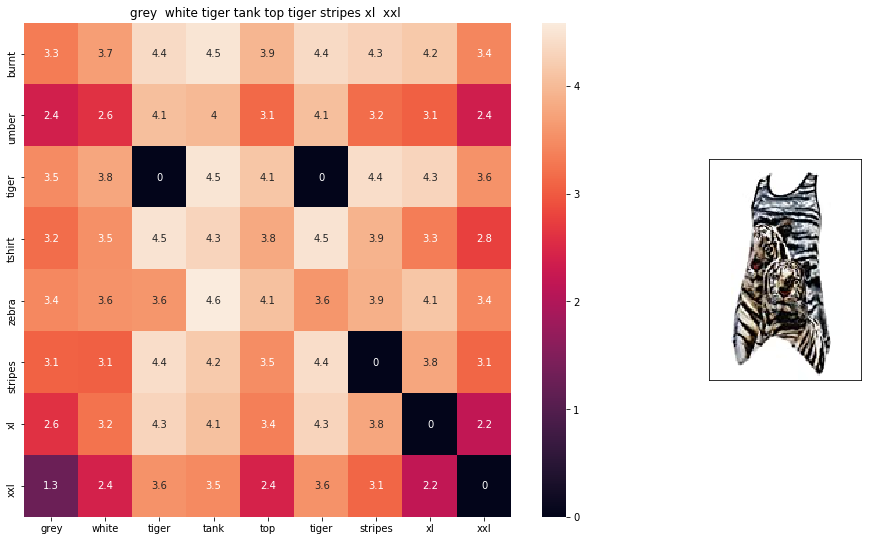

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.8928398


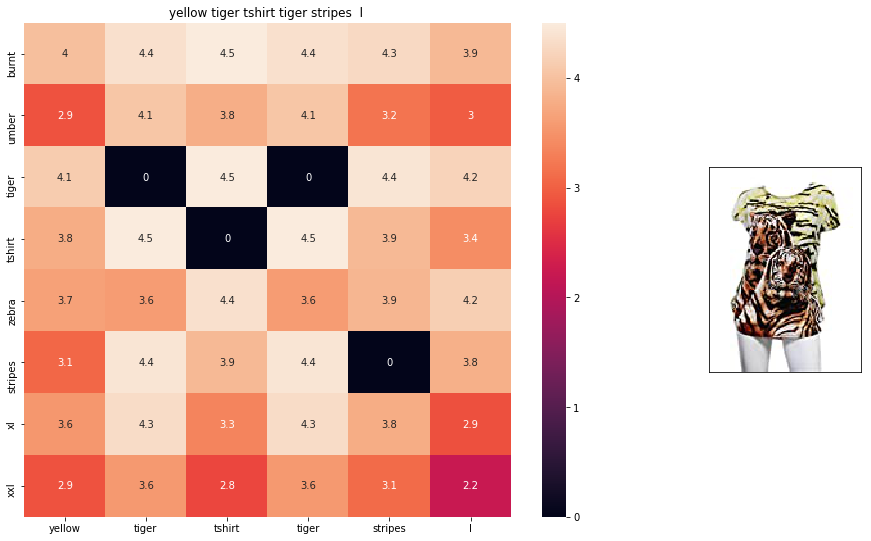

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.9560129


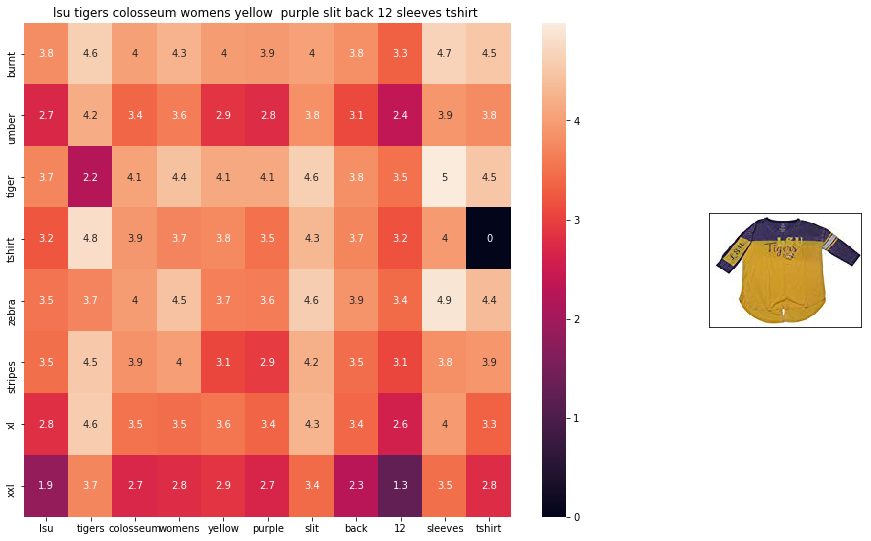

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.0229691


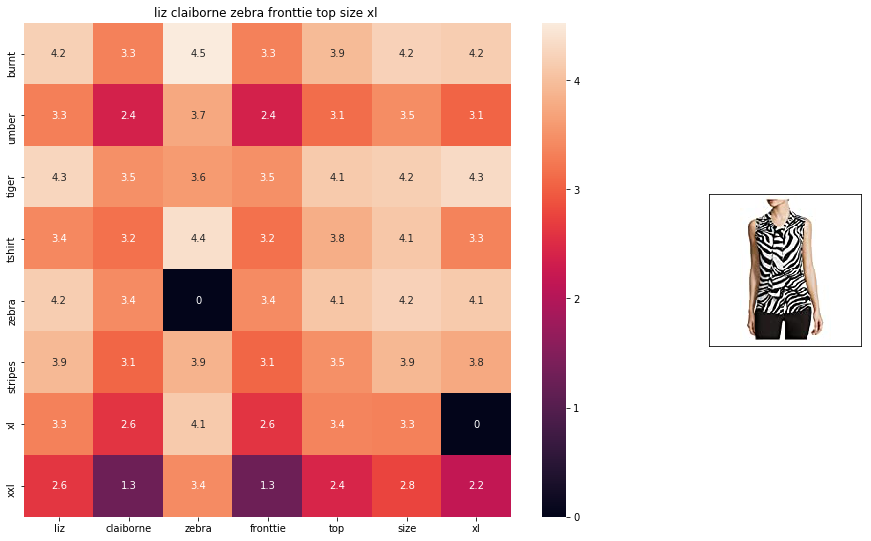

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324


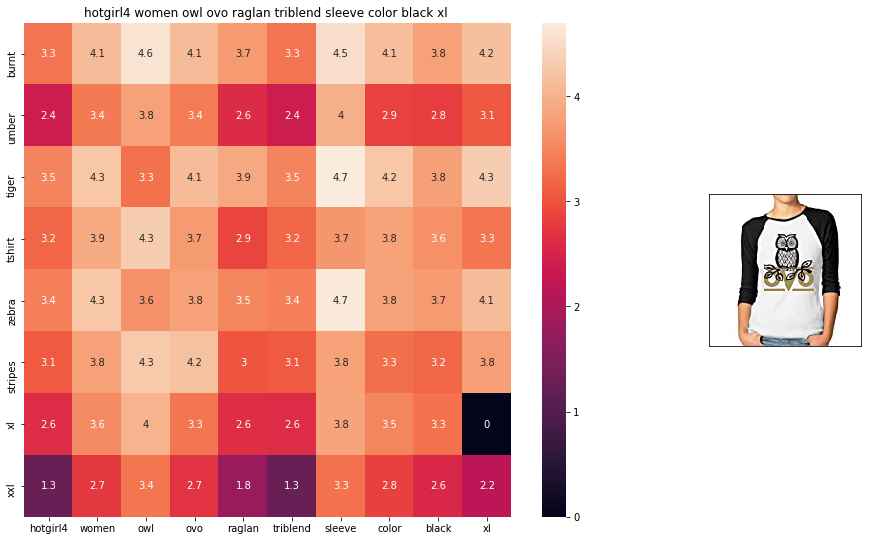

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731406


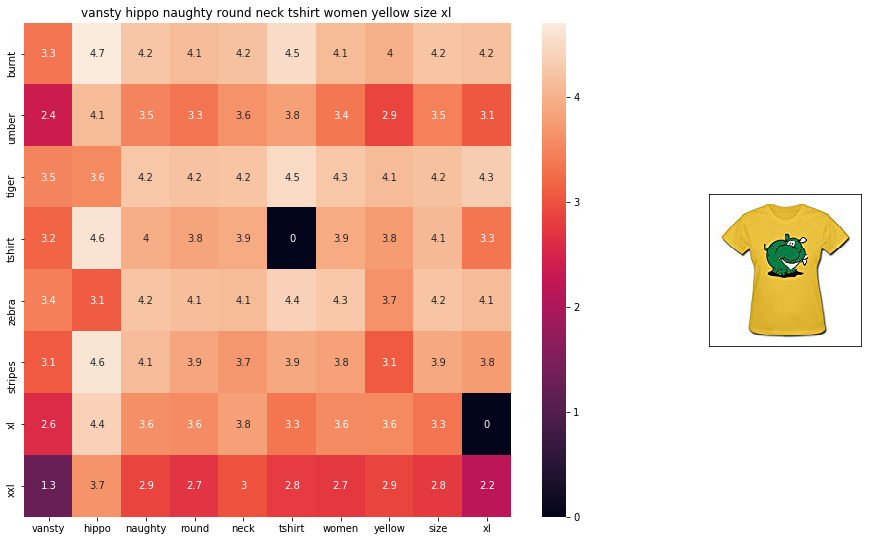

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719


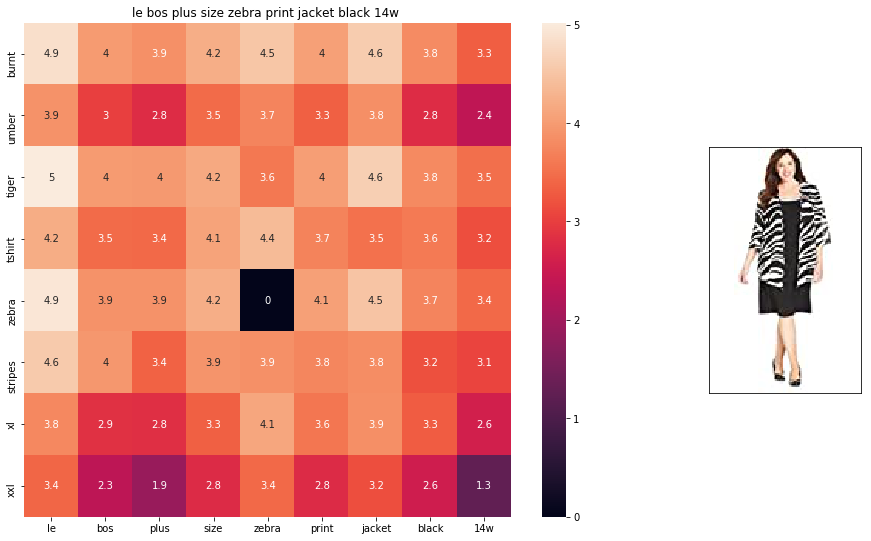

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.0839967


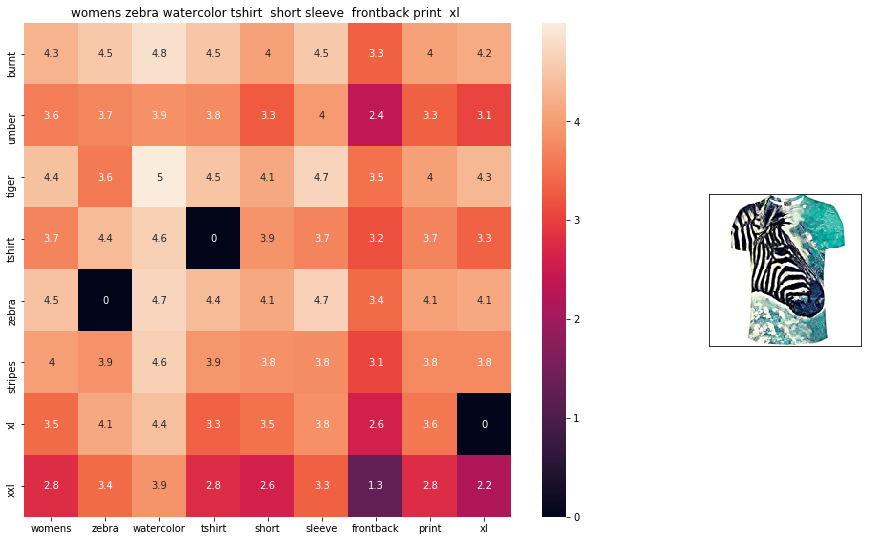

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.0842221


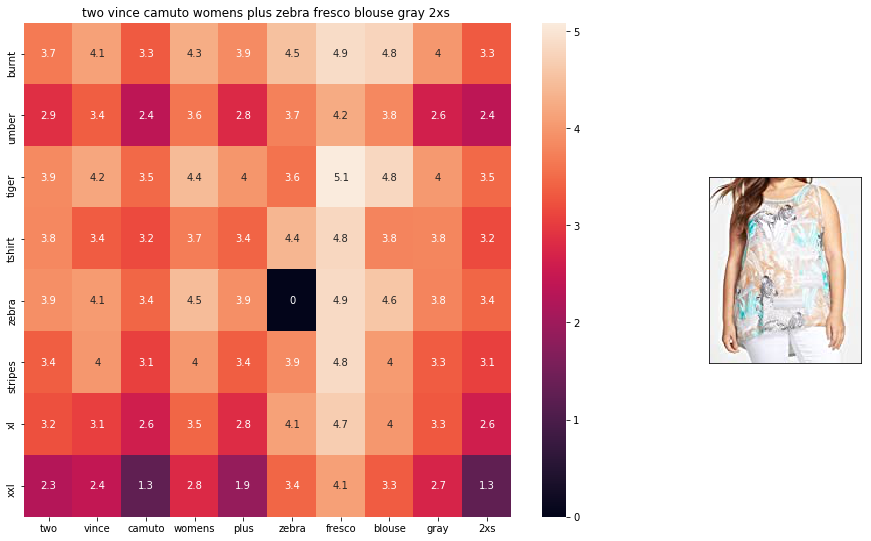

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895039


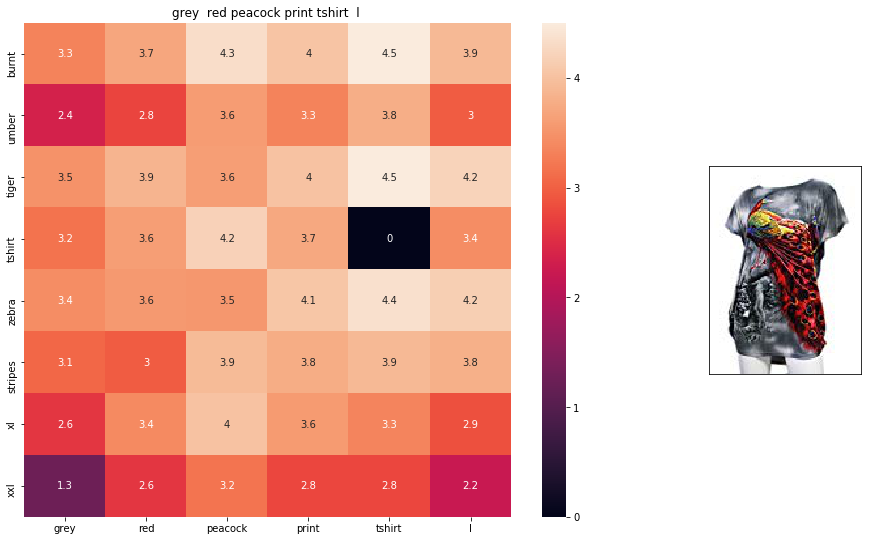

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.0900588


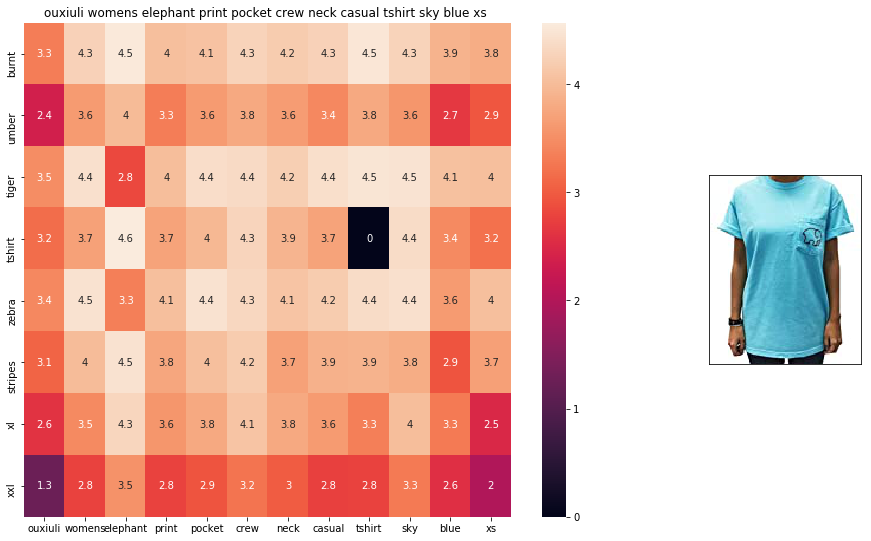

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.0920112


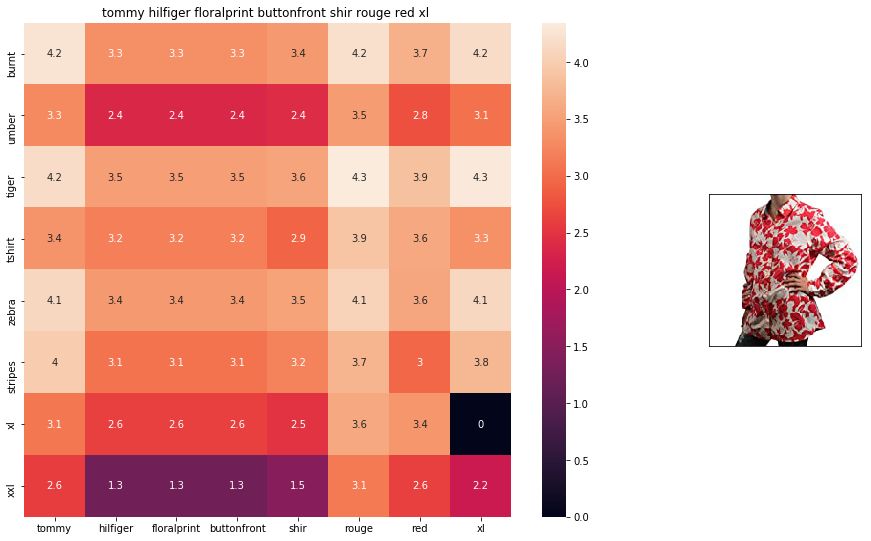

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0923418


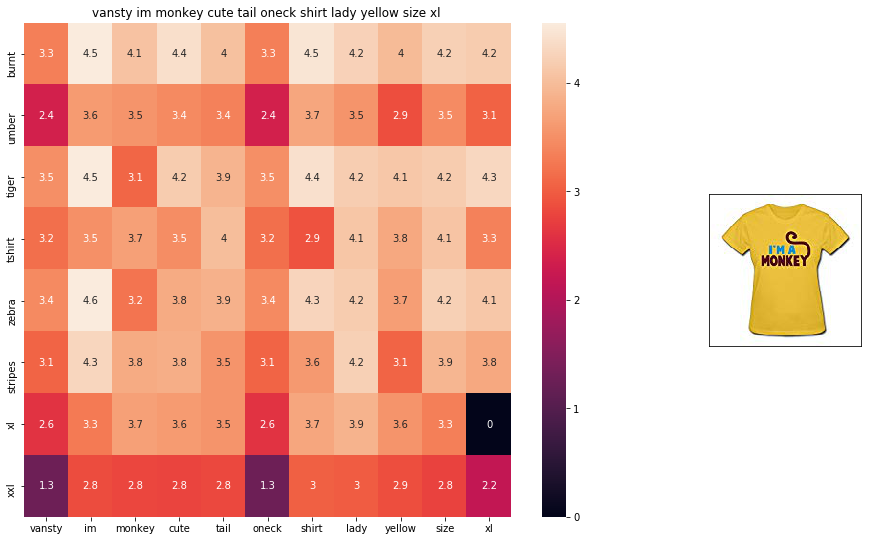

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934004


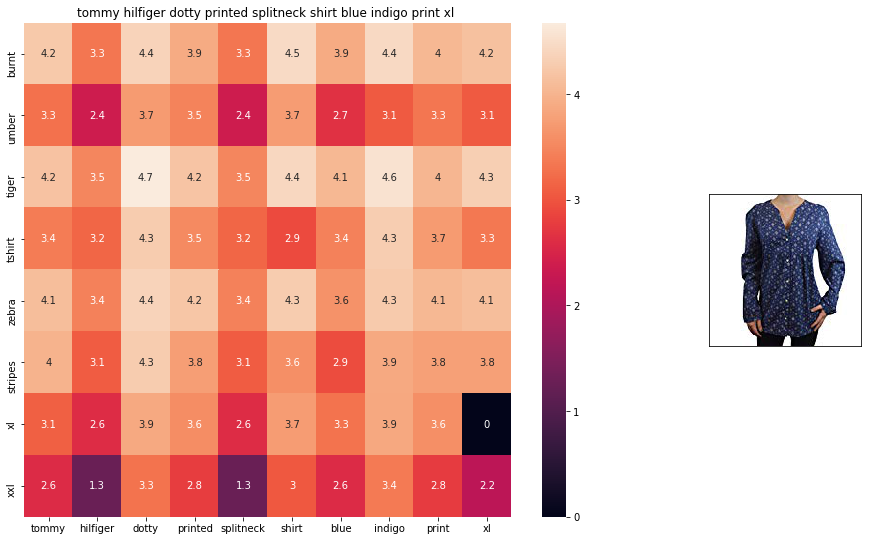

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942026


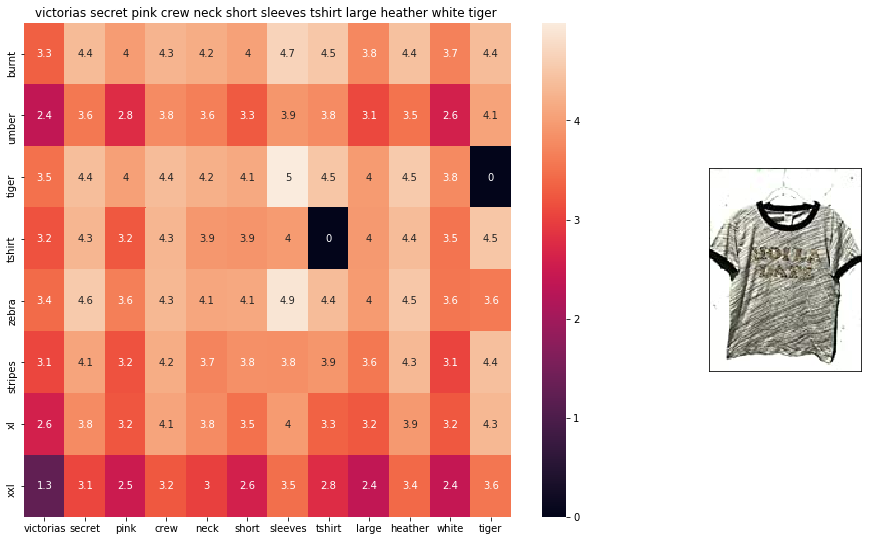

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.0948306


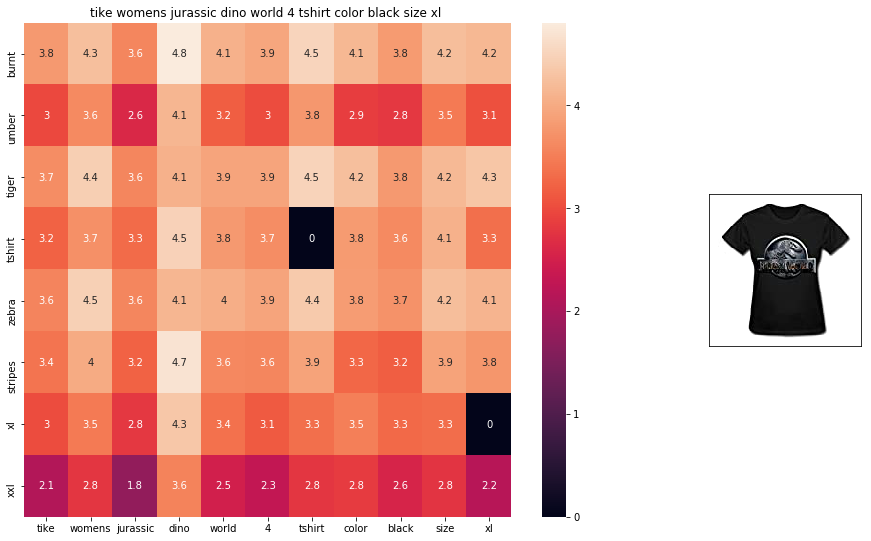

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.0951275


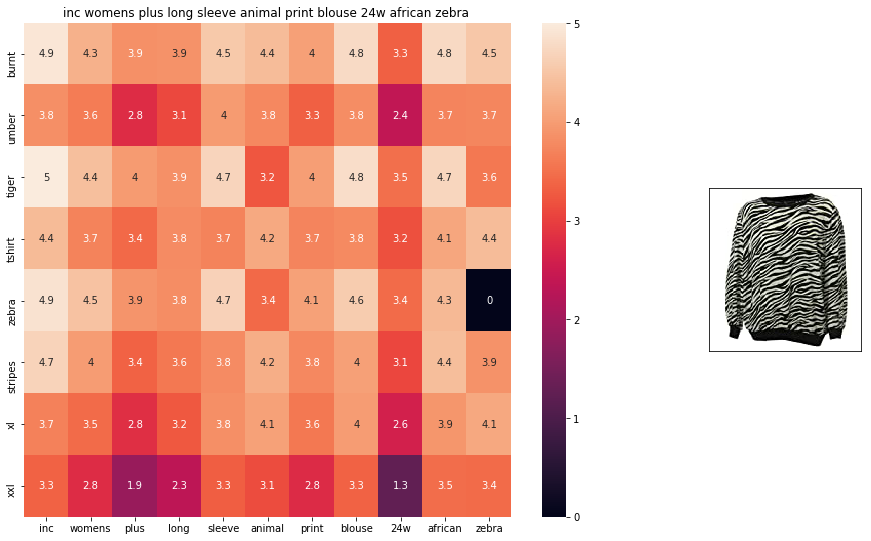

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.0966895


In [24]:
def avg_w2v_model(doc_id, num_results):
    
    
    pairwise_dist = pairwise_distances(w2v_title,w2v_title[doc_id].reshape(1,-1))
    
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)

###  Weighted similarity using brand and color.

In [16]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [17]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [22]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [19]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

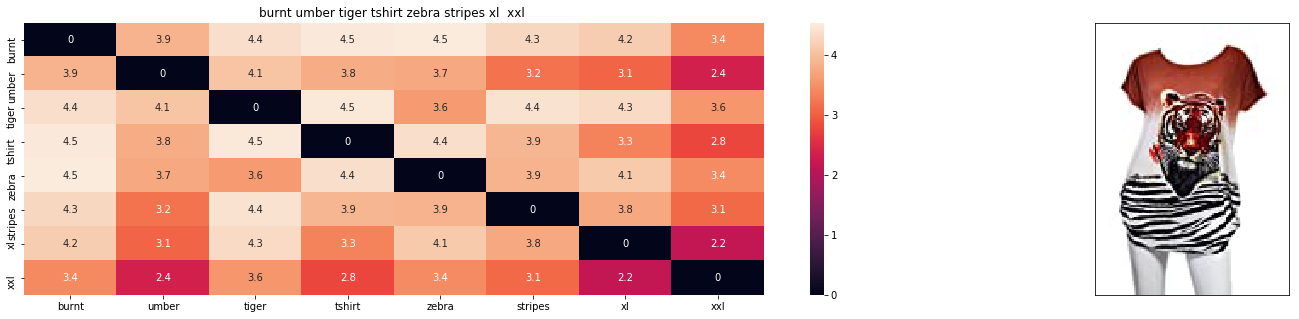

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


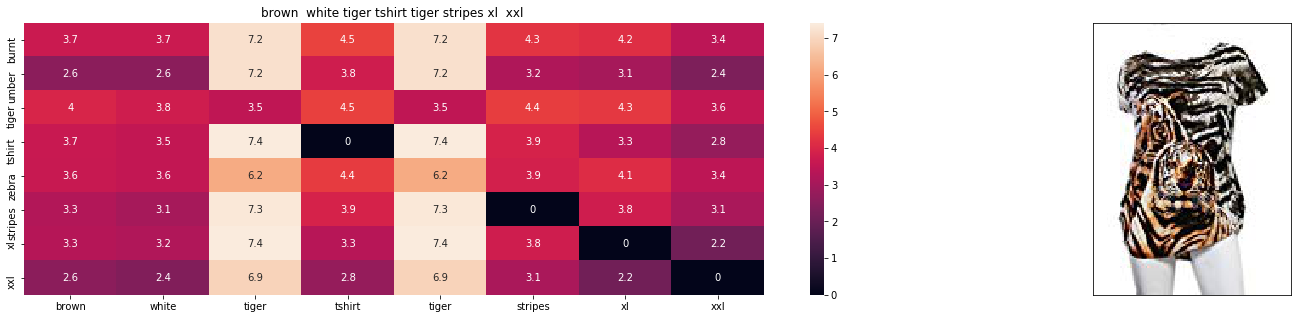

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 0.6528799057006835


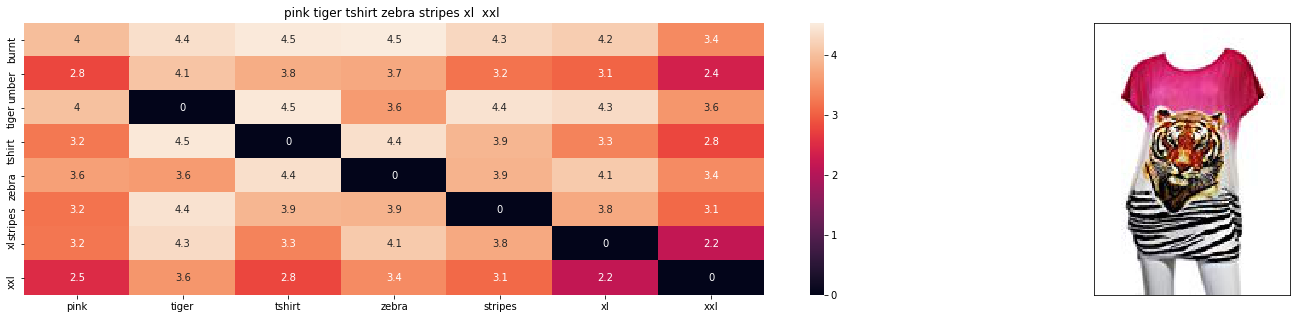

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 1.001703190984216


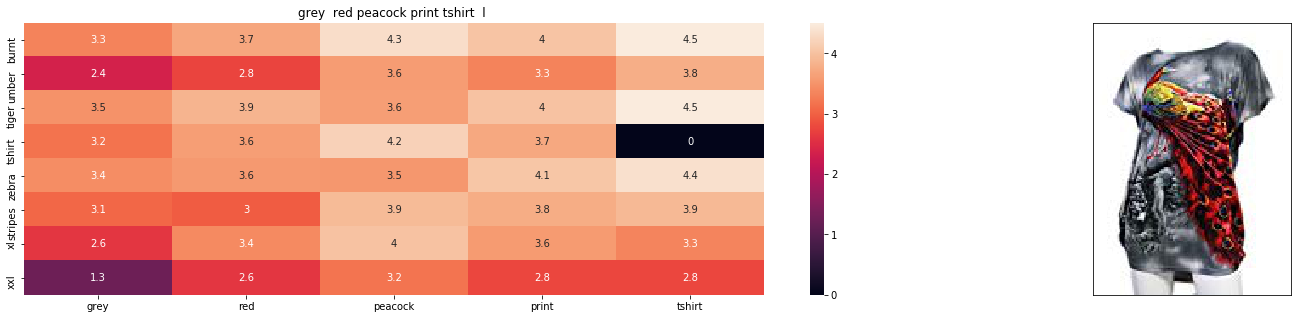

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 1.2372833730597166


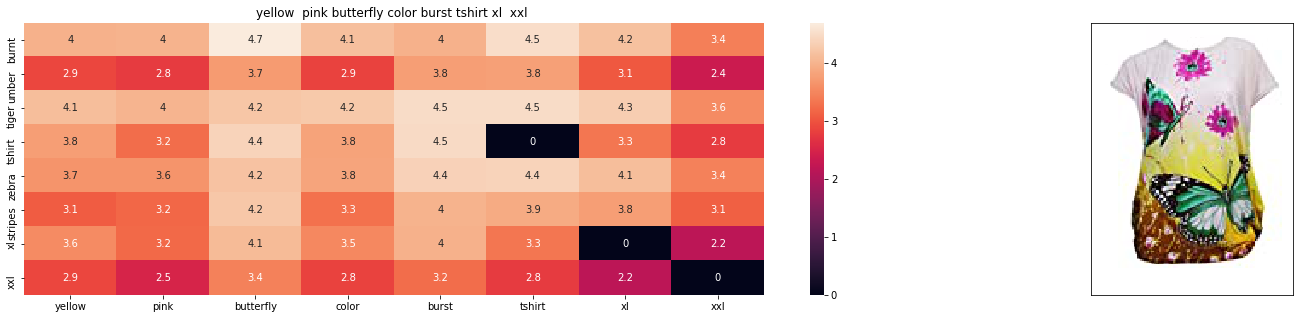

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 1.268622684659448


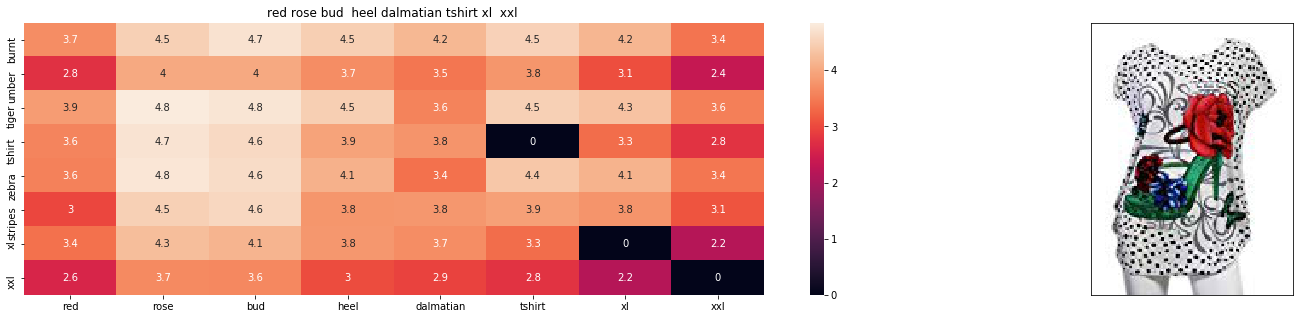

ASIN : B00JXQABB0
Brand : Si Row
euclidean distance from input : 1.2733485223669674


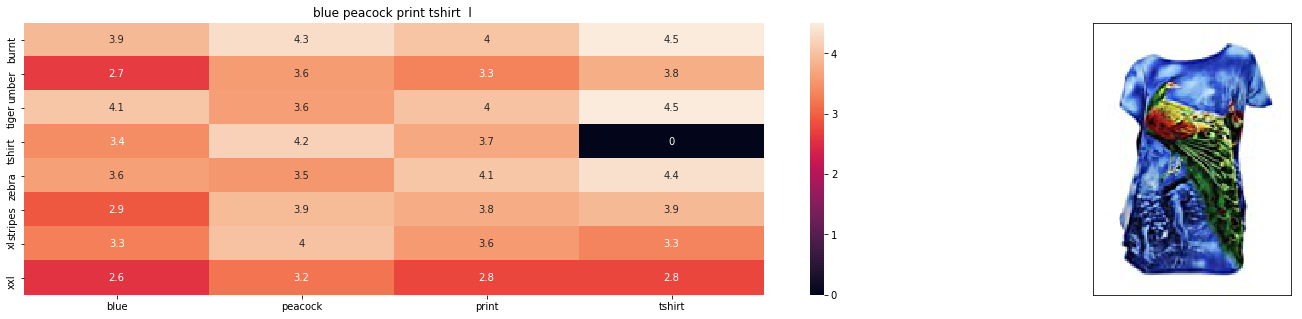

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 1.2818686963934567


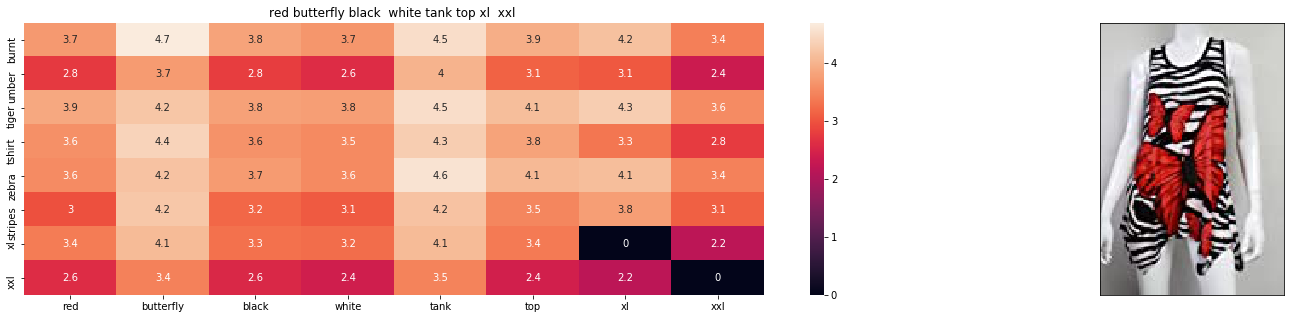

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 1.2947488786596921


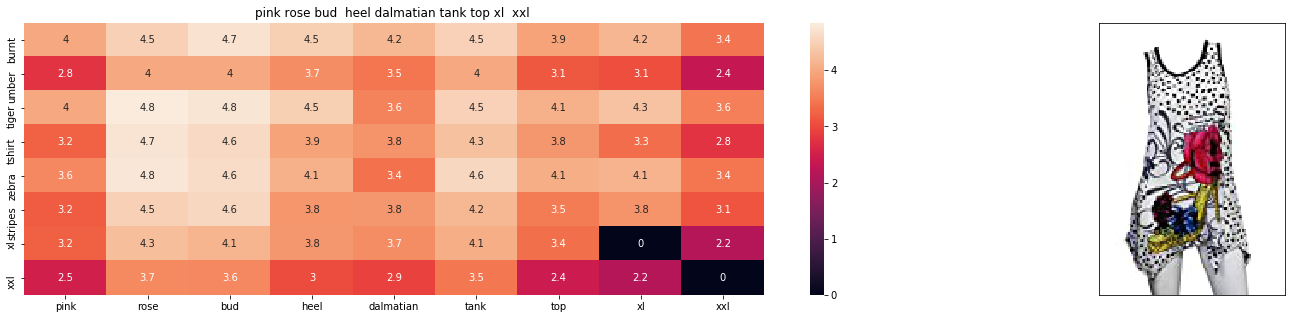

ASIN : B00JXQAX2C
Brand : Si Row
euclidean distance from input : 1.3236358644385007


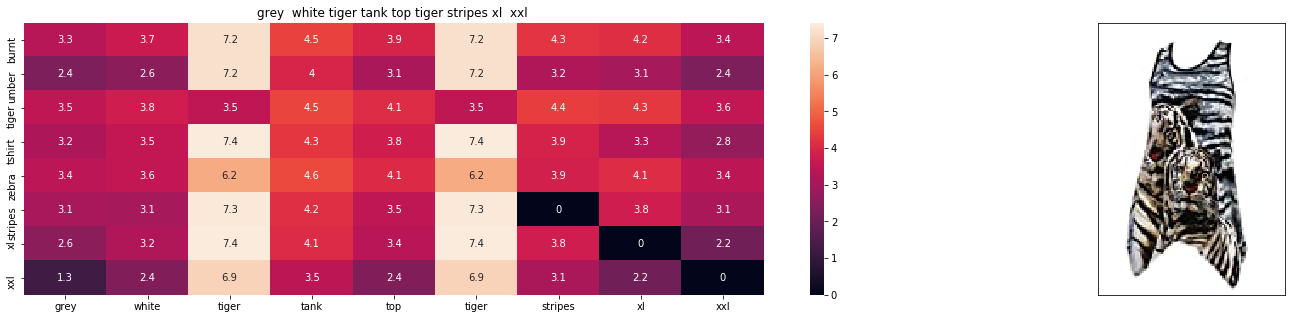

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 1.3293567659277585


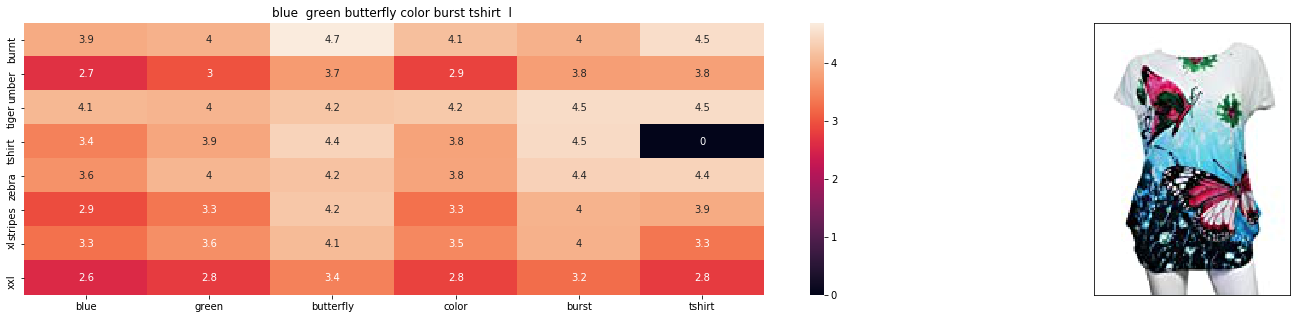

ASIN : B00JXQC0C8
Brand : Si Row
euclidean distance from input : 1.3499385358709959


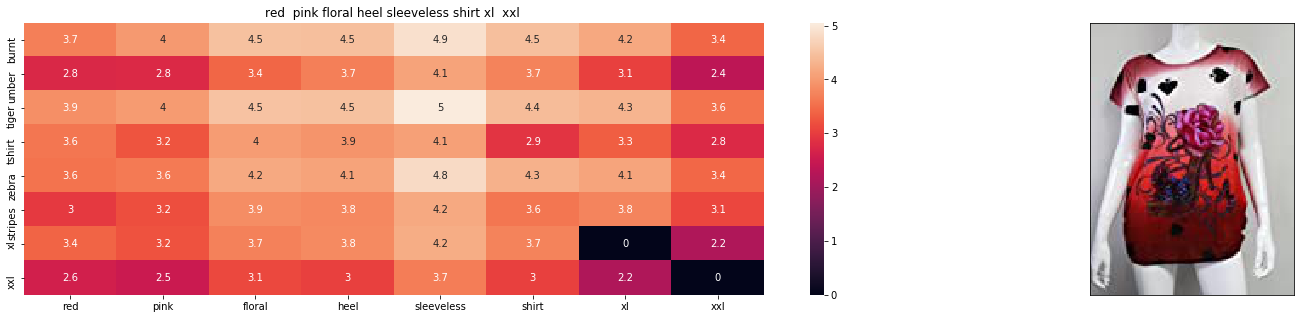

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 1.3649899007696775


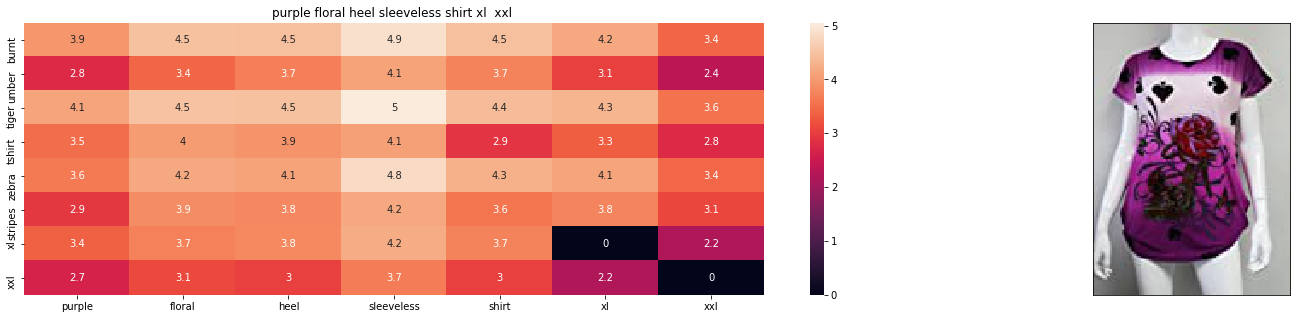

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from input : 1.408390236081567


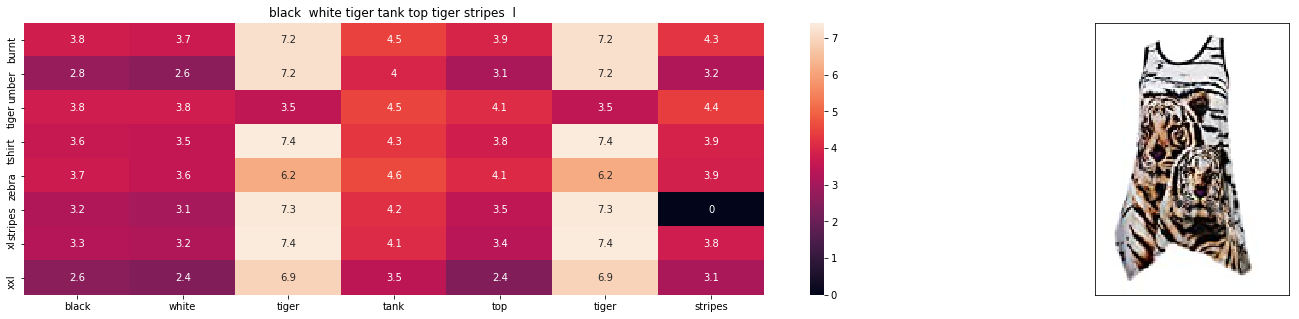

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 1.501950264157739


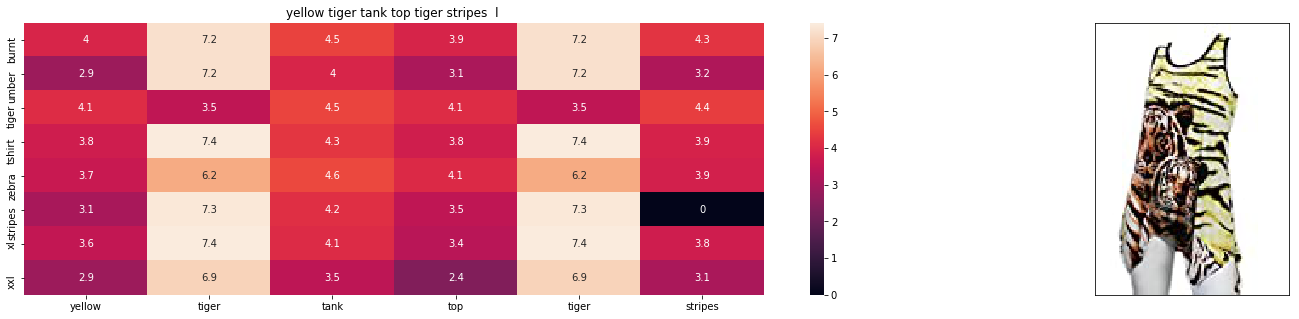

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 1.5693790437597896


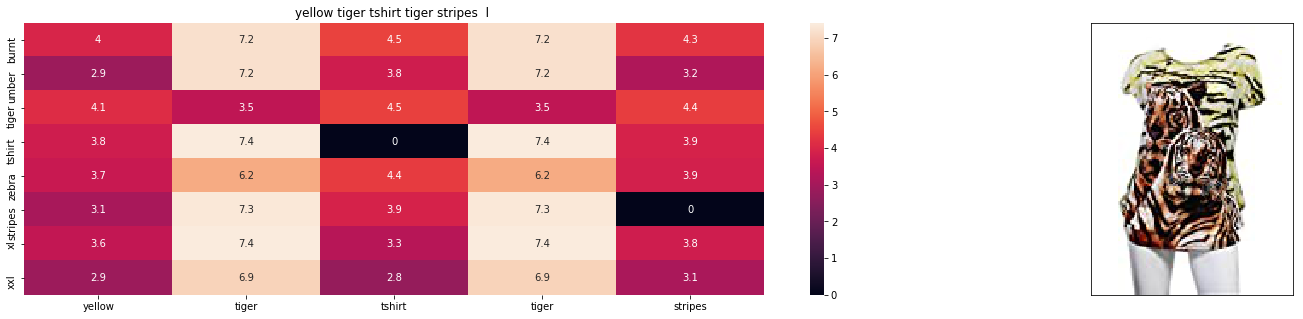

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 1.6333652498144773


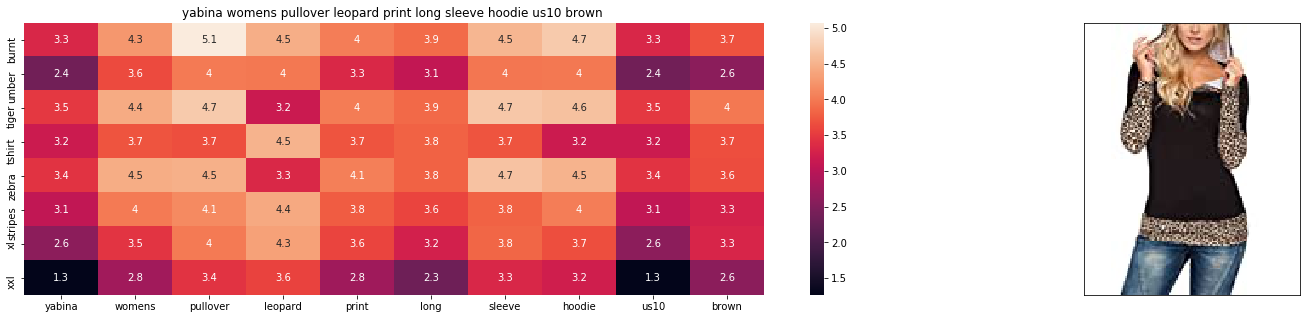

ASIN : B01KJUM6JI
Brand : YABINA
euclidean distance from input : 1.7323768689989183


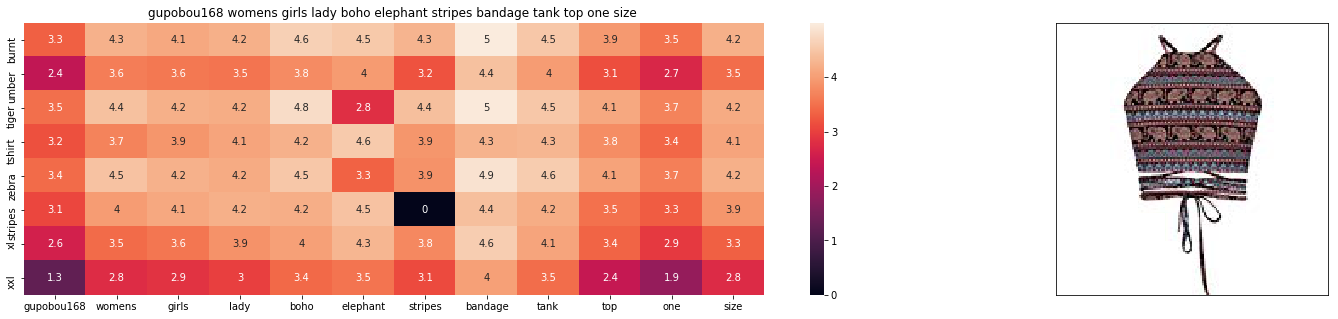

ASIN : B01ER184O6
Brand : GuPoBoU168
euclidean distance from input : 1.7352904394029711


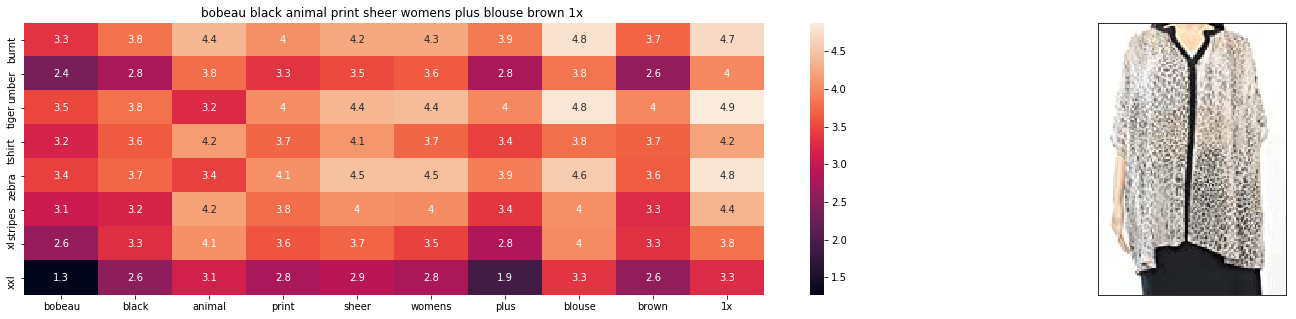

ASIN : B074MH886R
Brand : Bobeau
euclidean distance from input : 1.7428852632402514


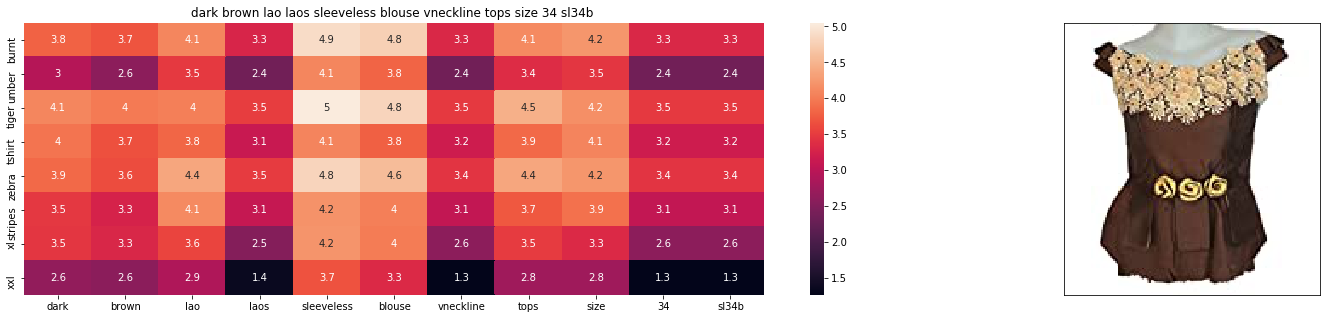

ASIN : B074J48RGW
Brand : Nanon
euclidean distance from input : 1.7484709337114428


In [23]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Keras and Tensorflow to extract features

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


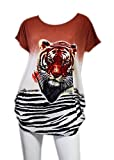

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.07654656
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


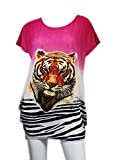

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.050104
Amazon Url: www.amzon.com/dp/B00JXQASS6


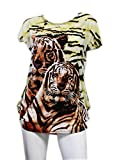

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.26115
Amazon Url: www.amzon.com/dp/B00JXQCUIC


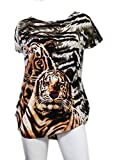

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.0002
Amazon Url: www.amzon.com/dp/B00JXQCWTO


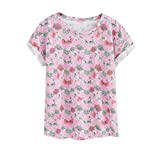

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.382504
Amazon Url: www.amzon.com/dp/B071FCWD97


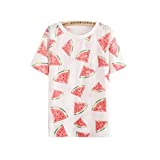

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.718403
Amazon Url: www.amzon.com/dp/B01JUNHBRM


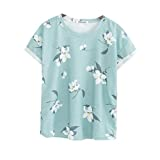

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.902092
Amazon Url: www.amzon.com/dp/B071SBCY9W


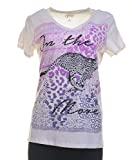

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046467
Amazon Url: www.amzon.com/dp/B01CUPYBM0


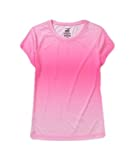

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101856
Amazon Url: www.amzon.com/dp/B01F7PHXY8


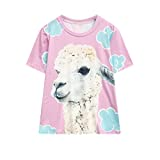

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118896
Amazon Url: www.amzon.com/dp/B01I80A93G


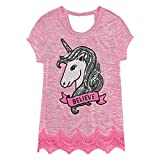

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.13128
Amazon Url: www.amzon.com/dp/B0177DM70S


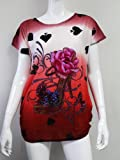

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.16946
Amazon Url: www.amzon.com/dp/B00JV63QQE


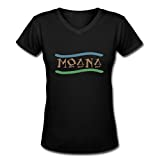

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.25678
Amazon Url: www.amzon.com/dp/B01LX6H43D


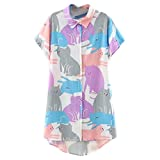

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.265633
Amazon Url: www.amzon.com/dp/B01CR57YY0


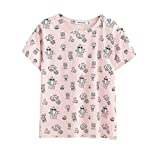

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.362564
Amazon Url: www.amzon.com/dp/B071WYLBZS


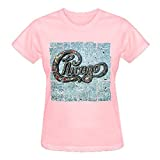

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.383648
Amazon Url: www.amzon.com/dp/B01GXAZTRY


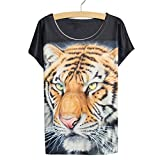

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.449333
Amazon Url: www.amzon.com/dp/B010NN9RXO


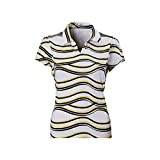

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.478893
Amazon Url: www.amzon.com/dp/B01MPX6IDX


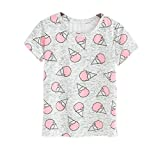

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.557983
Amazon Url: www.amzon.com/dp/B0734GRKZL


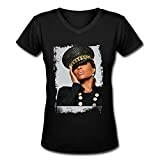

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.614414
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [3]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)
